Subcritical regions: 100.0%
Supercritical regions: 0.0%


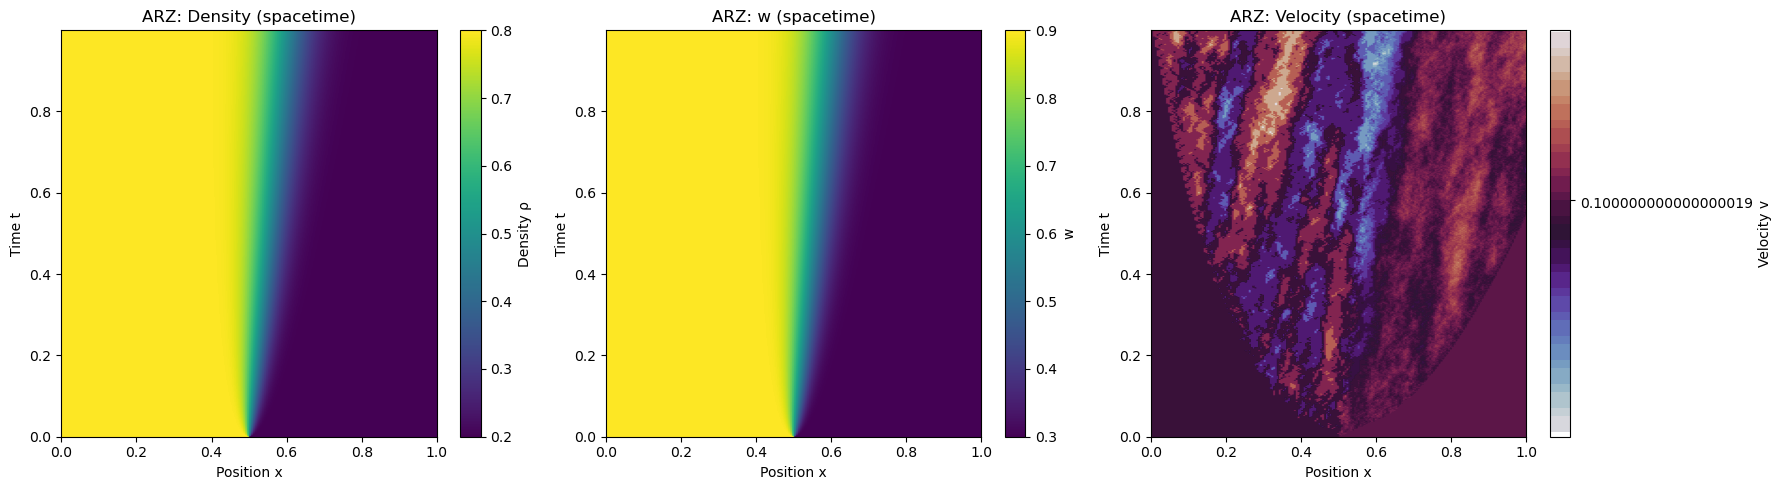

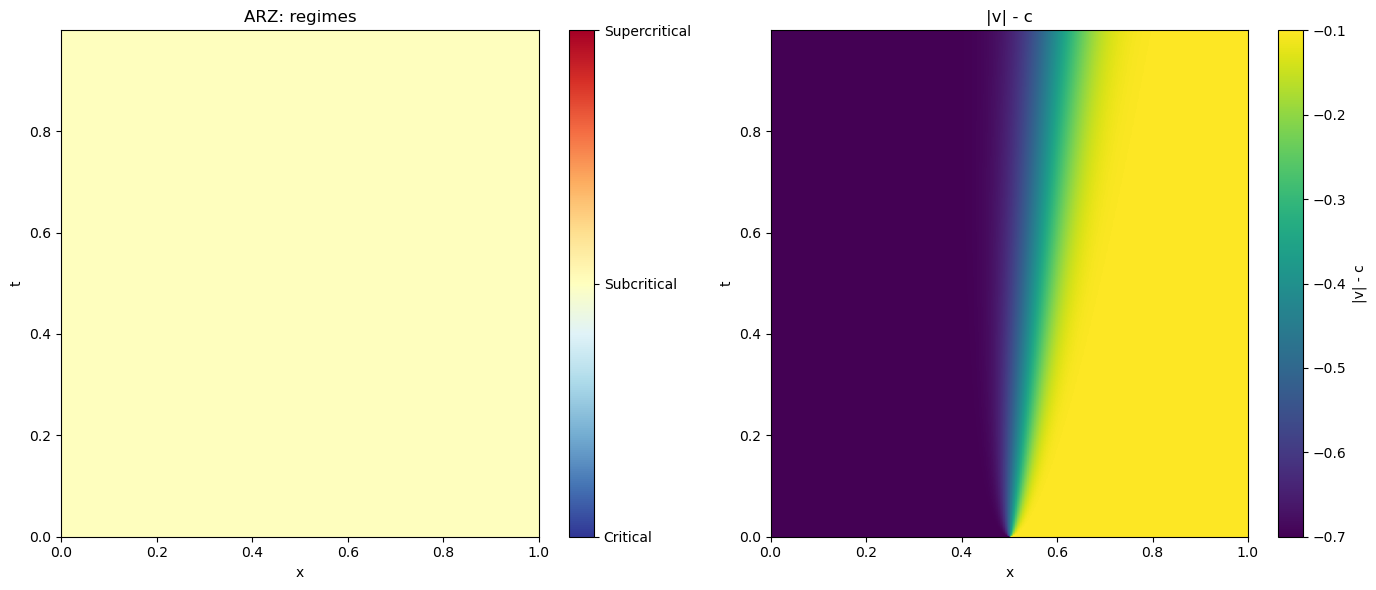

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Grid parameters
nx = 200
T = 1.0
x = np.linspace(0, 1, nx)
dx = x[1] - x[0]
dt = 0.4*dx  # CFL condition
nt = int(T / dt)
time_steps = nt

# ARZ model parameters
gamma = 1.0  # pressure exponent

def p(rho, gamma=gamma):
    # traffic pressure function
    return rho ** gamma

def dp_drho(rho, gamma=gamma):
    # derivative of traffic pressure with respect to density
    if gamma == 1.0:
        return gamma
    return gamma * (rho ** (gamma - 1))

def godunov_riemann(uL, uR, gamma=gamma):
    """Rusanov flux for ARZ model"""
    rhoL, wL = uL
    rhoR, wR = uR
    
    # Velocities
    vL = wL - p(rhoL, gamma)
    vR = wR - p(rhoR, gamma)
    
    # Fluxes of density and effective velocity (convective flux)
    fL = np.array([rhoL * vL, wL * vL])
    fR = np.array([rhoR * vR, wR * vR])
    
    # Max propagation speed
    smax = max(abs(vL) + abs(dp_drho(rhoL, gamma)),
               abs(vR) + abs(dp_drho(rhoR, gamma)))
    
    # Rusanov flux
    return 0.5*(fL + fR) - 0.5*smax*(np.array([rhoR, wR]) - np.array([rhoL, wL]))

def arz_solver(rho0, w0, dx, dt, nt, gamma=gamma):

    nx = len(rho0)

    rho_history = np.zeros((nt+1, nx))
    w_history = np.zeros((nt+1, nx))
    v_history = np.zeros((nt+1, nx))
    
    rho = rho0.copy()
    w = w0.copy()
    rho_history[0] = rho
    w_history[0] = w
    v_history[0] = w - p(rho, gamma)
    
    for n in range(nt):
        rho_new = rho.copy()
        w_new = w.copy()
        
        # Compute fluxes at interfaces
        fluxes = np.zeros((nx+1, 2))
        for i in range(nx+1):
            if i == 0:
                uL = np.array([rho[0], w[0]])
                uR = np.array([rho[0], w[0]])
            elif i == nx:
                uL = np.array([rho[-1], w[-1]])
                uR = np.array([rho[-1], w[-1]])
            else:
                uL = np.array([rho[i-1], w[i-1]])
                uR = np.array([rho[i], w[i]])
            fluxes[i] = godunov_riemann(uL, uR, gamma)
        
        # Update rho and w
        for i in range(nx):
            rho_new[i] = rho[i] - dt/dx*(fluxes[i+1,0] - fluxes[i,0])
            w_new[i] = w[i] - dt/dx*(fluxes[i+1,1] - fluxes[i,1])
        
        rho, w = rho_new, w_new
        
        rho_history[n+1] = rho
        w_history[n+1] = w
        v_history[n+1] = w - p(rho, gamma)
    
    return rho_history, w_history, v_history

# Initial conditions: shock in density 
rho0 = 0.2*np.ones(nx) 
rho0[x<0.5] = 0.8
v0 = 0.1*np.ones(nx)
w0 = v0 + p(rho0, gamma)

rho_history, w_history, v_history = arz_solver(rho0, w0, dx, dt, nt, gamma)
ntime, nx = rho_history.shape
T = dt * (ntime - 1) 

c_history = rho_history * dp_drho(rho_history, gamma)

lambda1 = v_history - c_history    # slower characteristic
lambda2 = v_history                # convective characteristic

tol = 1e-12
regime = np.zeros_like(v_history, dtype=np.int8)  # 0=critical,1=subcritical,2=supercritical

# critical (numerical near-zero characteristic)
crit_mask = (np.abs(lambda1) <= tol) | (np.abs(lambda2) <= tol)
regime[crit_mask] = 0

# subcritical: one negative, one positive
sub_mask = (lambda1 < 0) & (lambda2 > 0)
regime[sub_mask] = 1

# supercritical: both same sign (both >0 or both <0) -> one-way info
# here we treat both positive or both negative as supercritical
super_mask = (~crit_mask) & (~sub_mask)
regime[super_mask] = 2

subfraction = (regime == 1).sum() / regime.size
superfraction = (regime == 2).sum() / regime.size
print(f"Subcritical regions: {subfraction*100:.1f}%")
print(f"Supercritical regions: {superfraction*100:.1f}%")

x_left, x_right = x[0], x[-1]
t_left, t_right = 0.0, T

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(rho_history, aspect='auto', origin='lower',
           extent=[x_left, x_right, t_left, t_right])
plt.colorbar(label='Density ρ')
plt.xlabel('Position x'); plt.ylabel('Time t')
plt.title('ARZ: Density (spacetime)')

plt.subplot(1, 3, 2)
plt.imshow(w_history, aspect='auto', origin='lower',
           extent=[x_left, x_right, t_left, t_right])
plt.colorbar(label='w')
plt.xlabel('Position x'); plt.ylabel('Time t')
plt.title('ARZ: w (spacetime)')

plt.subplot(1, 3, 3)
plt.imshow(v_history, cmap='twilight', aspect='auto', origin='lower',
           extent=[x_left, x_right, t_left, t_right])
plt.colorbar(label='Velocity v')
plt.xlabel('Position x'); plt.ylabel('Time t')
plt.title('ARZ: Velocity (spacetime)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
im = plt.imshow(regime, cmap='RdYlBu_r', aspect='auto', origin='lower',
                extent=[x_left, x_right, t_left, t_right], vmin=0, vmax=2)
cbar = plt.colorbar(im, ticks=[0,1,2])
cbar.set_ticklabels(['Critical', 'Subcritical', 'Supercritical'])
plt.xlabel('x'); plt.ylabel('t')
plt.title('ARZ: regimes')


plt.subplot(1, 2, 2)
diff = np.abs(v_history) - c_history
plt.imshow(diff, aspect='auto', origin='lower', extent=[x_left, x_right, t_left, t_right])
plt.colorbar(label='|v| - c')
plt.contour(np.linspace(x_left, x_right, nx), np.linspace(t_left, t_right, ntime), diff, levels=[0], colors='k')
plt.xlabel('x'); plt.ylabel('t'); plt.title('|v| - c')

plt.tight_layout()
plt.show()


In [3]:
# ============================================================================
# EXAMPLE: Modified ARZ solver with different boundary conditions
# ============================================================================
# Uncomment and modify the solver to try different boundary conditions:

def arz_solver_with_bc(rho0, w0, dx, dt, nt, gamma=gamma, bc_type='zero_gradient'):

    nx = len(rho0)
    rho_history = np.zeros((nt+1, nx))
    w_history = np.zeros((nt+1, nx))
    v_history = np.zeros((nt+1, nx))
    
    rho = rho0.copy()
    w = w0.copy()
    rho_history[0] = rho
    w_history[0] = w
    v_history[0] = w - p(rho, gamma)
    
    # Boundary conditions
    rho_left = 0.5
    v_left = 1.0
    w_left = v_left + p(rho_left, gamma)
    
    rho_right = 0.3
    v_right = 0.5
    w_right = v_right + p(rho_right, gamma)
    
    for n in range(nt):
        t = n * dt
        rho_new = rho.copy()
        w_new = w.copy()

        if bc_type == 'periodic':
            # Periodic
            rho_with_ghost = np.concatenate([[rho[-1]], rho, [rho[0]]])
            w_with_ghost = np.concatenate([[w[-1]], w, [w[0]]])
        elif bc_type == 'inflow_outflow':
            # Left: fixed inflow, Right: zero gradient
            rho_with_ghost = np.concatenate([[rho_left], rho, [rho[-1]]])
            w_with_ghost = np.concatenate([[w_left], w, [w[-1]]])
        elif bc_type == 'time_varying_inflow':
            # Left: time-varying (sinusoidal), Right: zero gradient
            rho_left_t = rho_left + 2 * np.sin(2 * np.pi * t / 2.0)
            v_left_t = v_left + 0.1 * np.sin(2 * np.pi * t / 1.5)
            w_left_t = v_left_t + p(rho_left_t, gamma)
            rho_with_ghost = np.concatenate([[rho_left_t], rho, [rho[-1]]])
            w_with_ghost = np.concatenate([[w_left_t], w, [w[-1]]])
        elif bc_type == 'dirichlet':
            # Fixed values at both boundaries
            rho_with_ghost = np.concatenate([[rho_left], rho, [rho_right]])
            w_with_ghost = np.concatenate([[w_left], w, [w_right]])
        else:  # 'zero_gradient' (default)
            # Zero gradient (reflecting)
            rho_with_ghost = np.concatenate([[rho[0]], rho, [rho[-1]]])
            w_with_ghost = np.concatenate([[w[0]], w, [w[-1]]])
        
        # Compute fluxes at interfaces
        fluxes = np.zeros((nx+1, 2))
        for i in range(nx+1):
            uL = np.array([rho_with_ghost[i], w_with_ghost[i]])
            uR = np.array([rho_with_ghost[i+1], w_with_ghost[i+1]])
            fluxes[i] = godunov_riemann(uL, uR, gamma)
        
        # Update rho and w
        for i in range(nx):
            rho_new[i] = rho[i] - dt/dx*(fluxes[i+1,0] - fluxes[i,0])
            w_new[i] = w[i] - dt/dx*(fluxes[i+1,1] - fluxes[i,1])
        
        rho, w = rho_new, w_new
        
        rho_history[n+1] = rho
        w_history[n+1] = w
        v_history[n+1] = w - p(rho, gamma)
    
    return rho_history, w_history, v_history

# Example usage (uncomment to try):
# rho_history, w_history, v_history = arz_solver_with_bc(
#     rho0, w0, dx, dt, nt, gamma, bc_type='time_varying_inflow'
# )


# ============================================================================
# Plotting function for ARZ results
# ============================================================================

def plot_arz_results(rho_history, w_history, v_history, x, dt, gamma, title_suffix=""):
    ntime, nx = rho_history.shape
    T = dt * (ntime - 1)
    
    # Compute characteristic speeds and regime
    c_history = rho_history * dp_drho(rho_history, gamma)
    lambda1 = v_history - c_history
    lambda2 = v_history
    
    tol = 1e-12
    regime = np.zeros_like(v_history, dtype=np.int8)
    
    crit_mask = (np.abs(lambda1) <= tol) | (np.abs(lambda2) <= tol)
    regime[crit_mask] = 0
    
    # subcritical: one negative, one positive
    sub_mask = (lambda1 < 0) & (lambda2 > 0)
    regime[sub_mask] = 1
    
    # supercritical: both same sign
    super_mask = (~crit_mask) & (~sub_mask)
    regime[super_mask] = 2
    
    subfraction = (regime == 1).sum() / regime.size
    superfraction = (regime == 2).sum() / regime.size
    print(f"\n{title_suffix} Results:")
    print(f"  Subcritical regions: {subfraction*100:.1f}%")
    print(f"  Supercritical regions: {superfraction*100:.1f}%")
    
    x_left, x_right = x[0], x[-1]
    t_left, t_right = 0.0, T
    
    # Figure 1: Main variables
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(rho_history, aspect='auto', origin='lower',
               extent=[x_left, x_right, t_left, t_right])
    plt.colorbar(label='Density ρ')
    plt.xlabel('Position x')
    plt.ylabel('Time t')
    plt.title(f'ARZ: Density (spacetime){title_suffix}')
    
    plt.subplot(1, 3, 2)
    plt.imshow(w_history, aspect='auto', origin='lower',
               extent=[x_left, x_right, t_left, t_right])
    plt.colorbar(label='w')
    plt.xlabel('Position x')
    plt.ylabel('Time t')
    plt.title(f'ARZ: w (spacetime){title_suffix}')
    
    plt.subplot(1, 3, 3)
    plt.imshow(v_history, cmap='twilight', aspect='auto', origin='lower',
               extent=[x_left, x_right, t_left, t_right])
    plt.colorbar(label='Velocity v')
    plt.xlabel('Position x')
    plt.ylabel('Time t')
    plt.title(f'ARZ: Velocity (spacetime){title_suffix}')
    
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Regime analysis
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    im = plt.imshow(regime, cmap='RdYlBu_r', aspect='auto', origin='lower',
                    extent=[x_left, x_right, t_left, t_right], vmin=0, vmax=2)
    cbar = plt.colorbar(im, ticks=[0, 1, 2])
    cbar.set_ticklabels(['Critical', 'Subcritical', 'Supercritical'])
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f'ARZ: Regimes{title_suffix}')

    
    plt.subplot(1, 2, 2)
    diff = np.abs(v_history) - c_history
    plt.imshow(diff, aspect='auto', origin='lower', 
               extent=[x_left, x_right, t_left, t_right])
    plt.colorbar(label='|v| - c')
    plt.contour(np.linspace(x_left, x_right, nx), 
                np.linspace(t_left, t_right, ntime), 
                diff, levels=[0], colors='k', linewidths=2)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f'|v| - c{title_suffix}')
    
    plt.tight_layout()
    plt.show()




Testing: zero_gradient

 - zero_gradient Results:
  Subcritical regions: 100.0%
  Supercritical regions: 0.0%


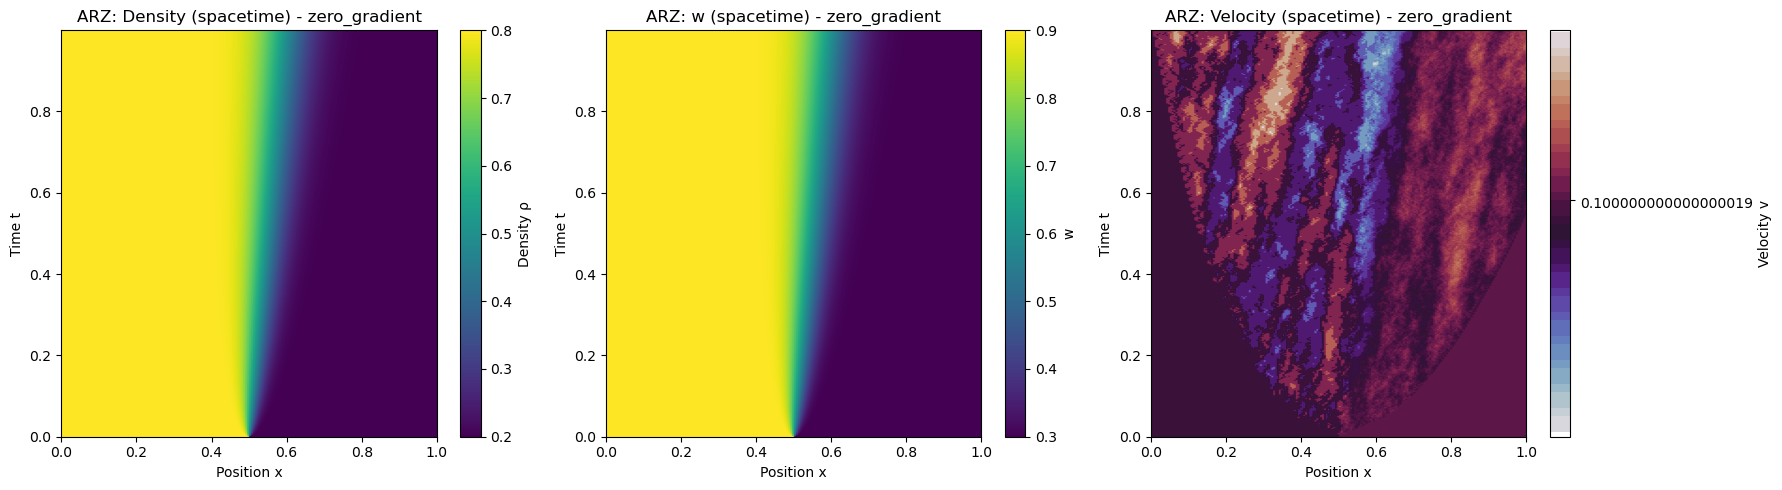

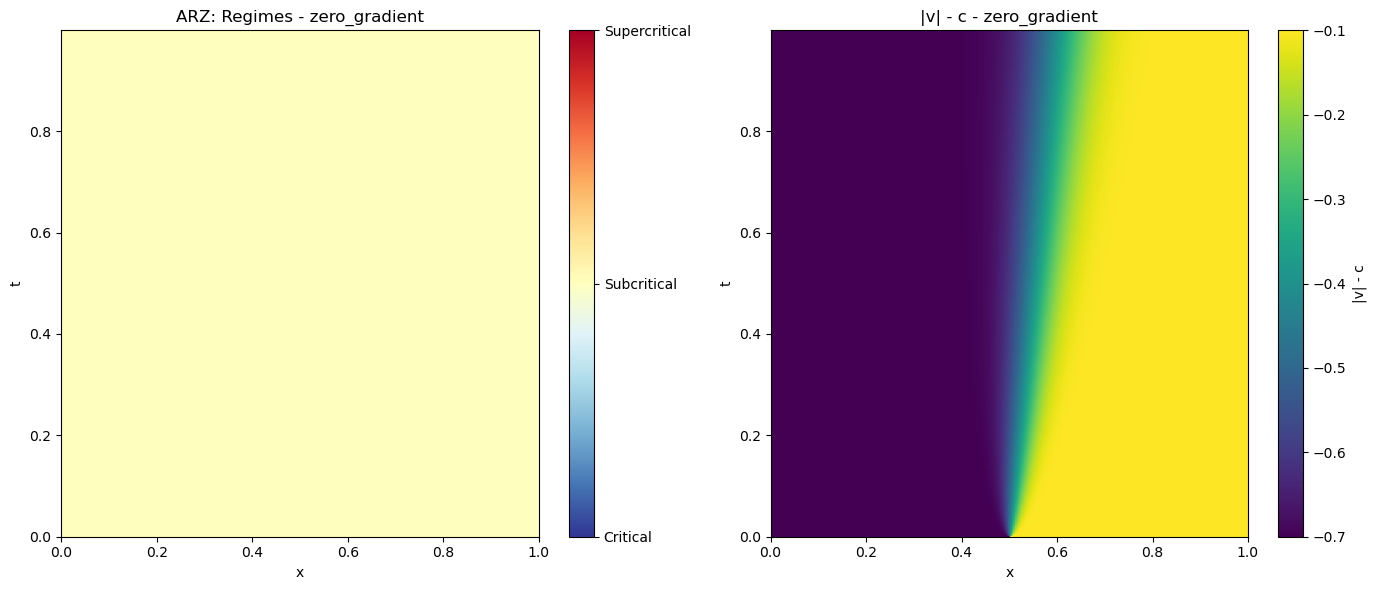


Testing: periodic

 - periodic Results:
  Subcritical regions: 100.0%
  Supercritical regions: 0.0%


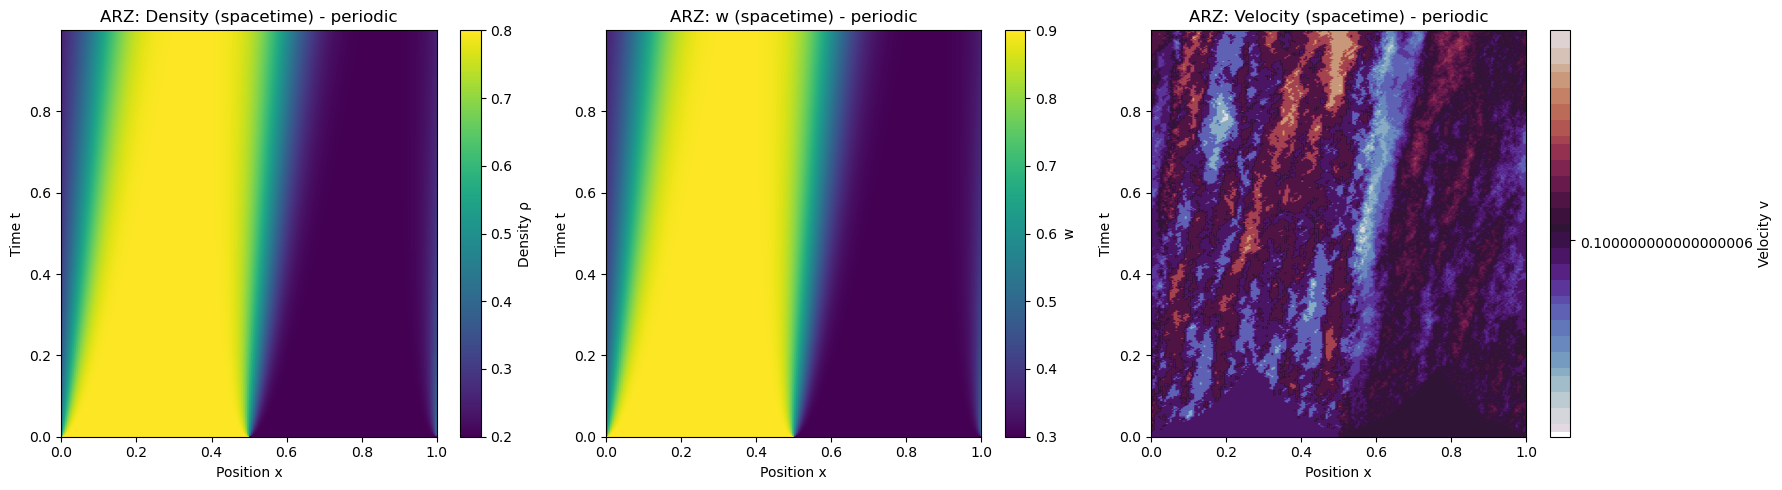

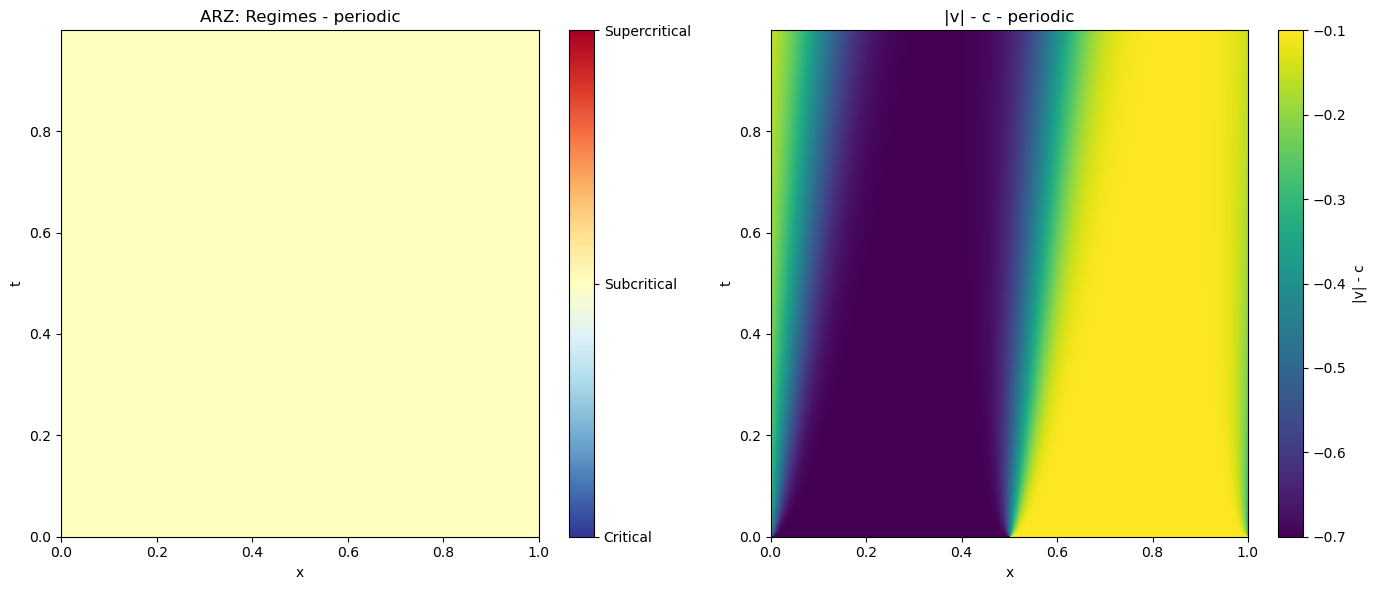


Testing: inflow_outflow

 - inflow_outflow Results:
  Subcritical regions: 57.9%
  Supercritical regions: 42.1%


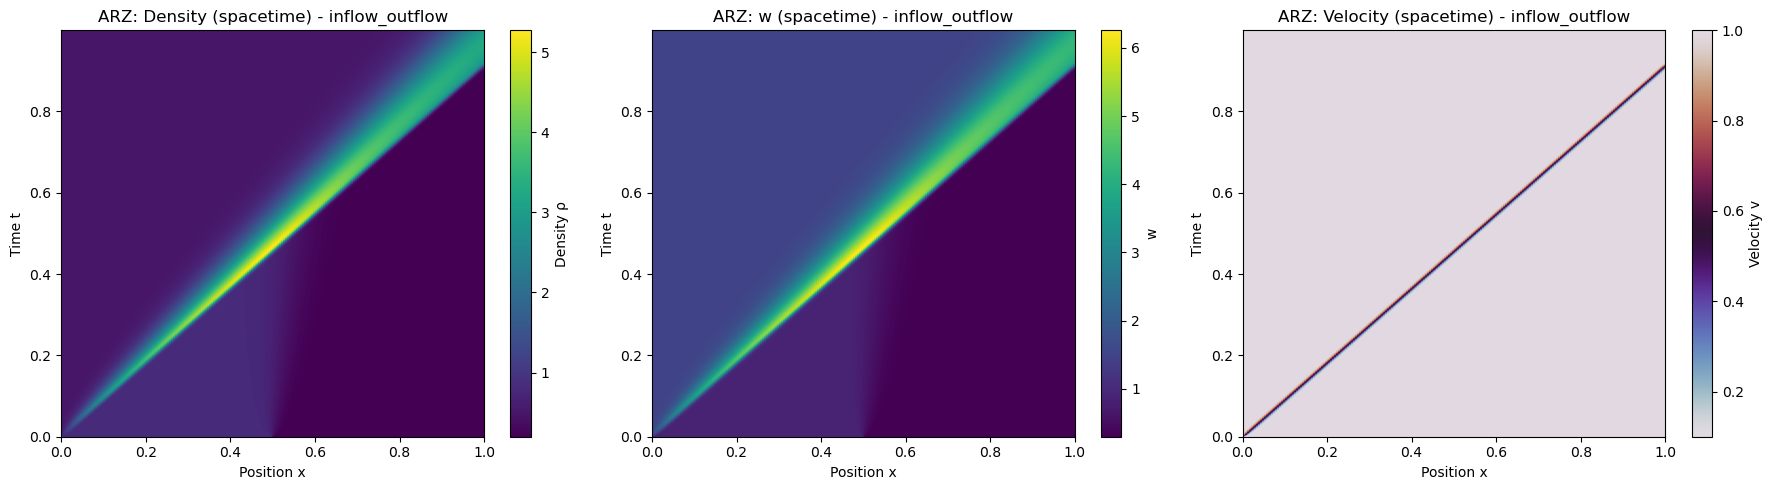

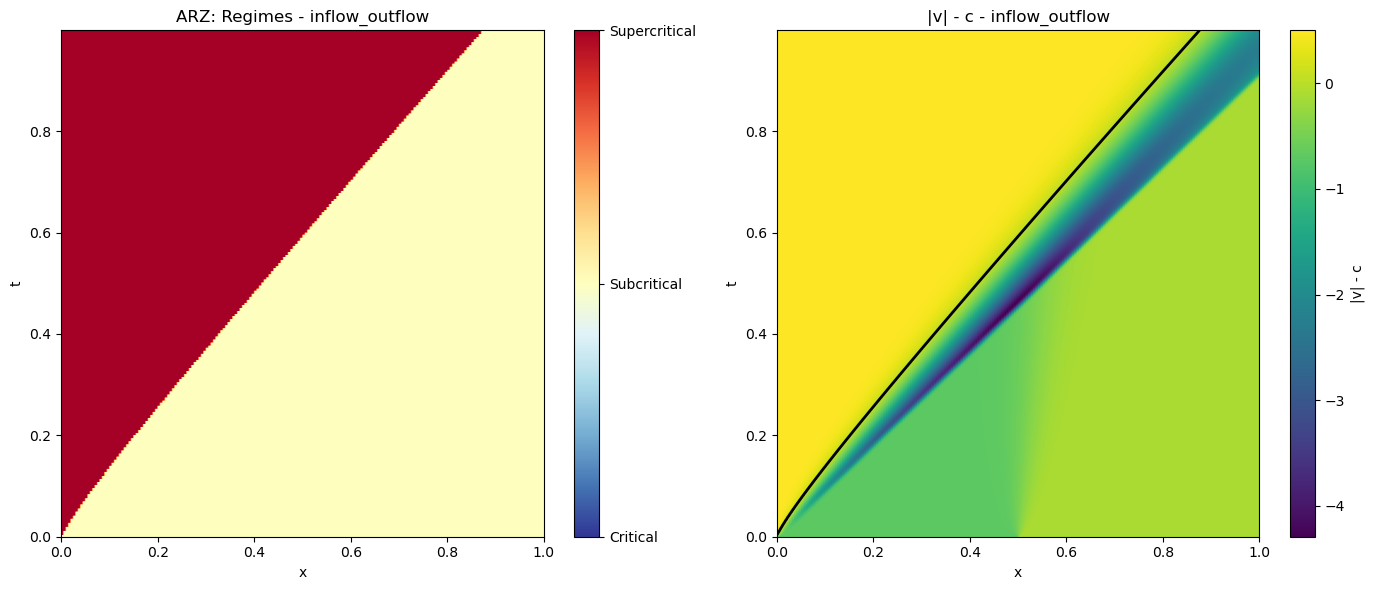


Testing: time_varying_inflow

 - time_varying_inflow Results:
  Subcritical regions: 99.2%
  Supercritical regions: 0.8%


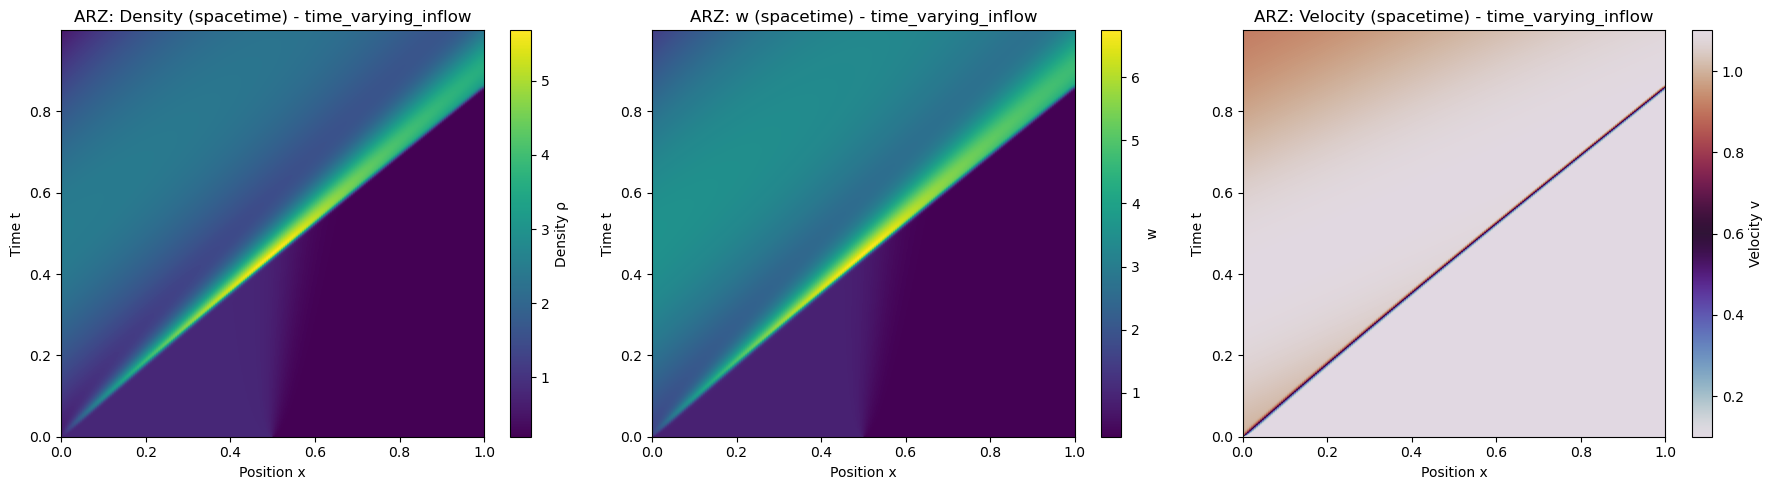

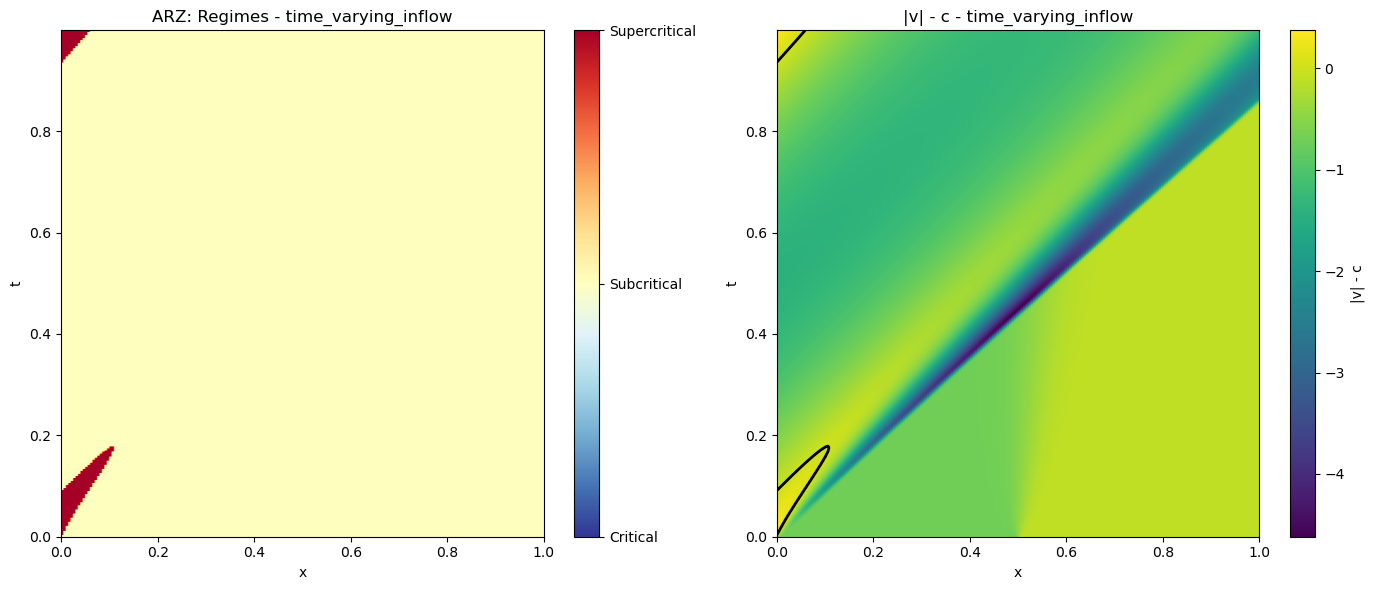


Testing: dirichlet

 - dirichlet Results:
  Subcritical regions: 56.5%
  Supercritical regions: 43.5%


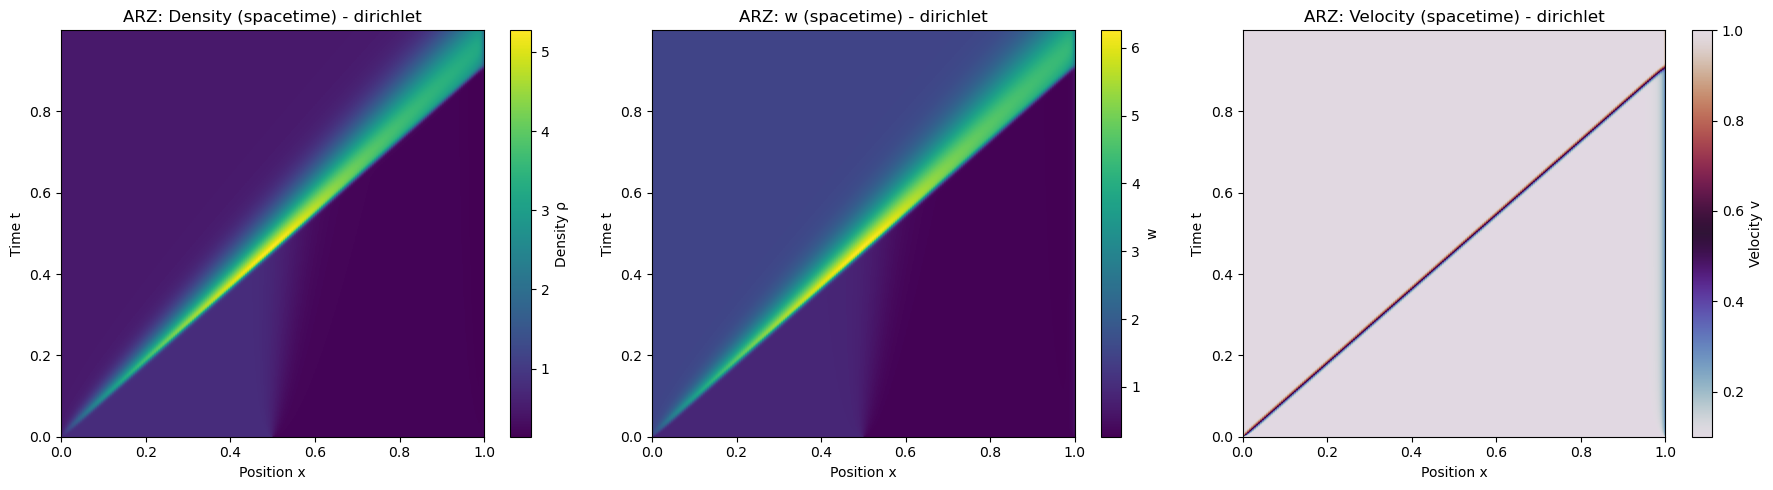

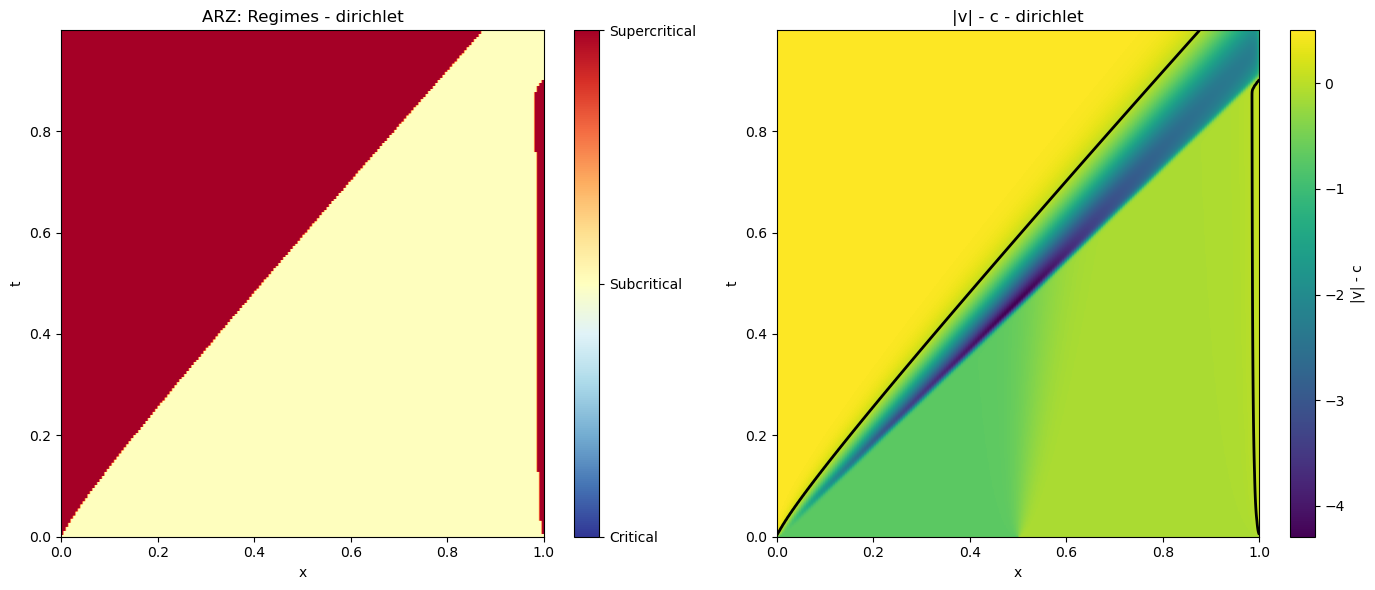

In [6]:

# Test different boundary conditions
bc_types = ['zero_gradient', 'periodic', 'inflow_outflow', 'time_varying_inflow', 'dirichlet']

# Uncomment the ones you want to test:
for bc_type in bc_types:
    print(f"\n{'='*60}")
    print(f"Testing: {bc_type}")
    print(f"{'='*60}")
    rho_hist, w_hist, v_hist = arz_solver_with_bc(
        rho0, w0, dx, dt, nt, gamma, bc_type=bc_type
    )
    plot_arz_results(rho_hist, w_hist, v_hist, x, dt, gamma, 
                     title_suffix=f" - {bc_type}")

# Or test just one:
# rho_hist, w_hist, v_hist = arz_solver_with_bc(
#     rho0, w0, dx, dt, nt, gamma, bc_type='time_varying_inflow'
# )
# plot_arz_results(rho_hist, w_hist, v_hist, x, dt, gamma, 
#                  title_suffix=" - Time Varying Inflow")

